In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
aaplHistIV = pd.read_pickle('/content/aapl_mean_iv_2017_2022.pkl')
googHistIV = pd.read_pickle('/content/goog_mean_iv_2017_2022.pkl')
msftHistIV = pd.read_pickle('/content/msft_mean_iv_2017_2022.pkl')
ndxHistIV = pd.read_pickle('/content/ndx_mean_iv_2017_2022.pkl')
spyHistIV = pd.read_pickle('/content/spc_mean_iv_2017_2022.pkl')


In [ ]:
spyHistIV.rename(columns = {'date':'Date'},inplace = True) #renaming date column to Date for consistency
spyHistIV.set_index('Date',inplace = True,drop = True) #setting index to date

In [ ]:
#grab spy  from yfinance

spyHistory = yf.download('^GSPC', start='2016-01-01', end='2023-12-31')
#calculate realised vol
window =21 #realisedVol window size
spyHistory['Daily Return'] = spyHistory['Adj Close'].pct_change()
spyHistory['21dRealisedVol'] = spyHistory['Daily Return'].rolling(window=window).std() * np.sqrt(252)
spyHistory.head()
#



[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Daily Return,21dRealisedVol
Date,,,,,,,,
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000,NaN,NaN
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000,0.002012,NaN
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000,-0.013115,NaN
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5076590000,-0.023700,NaN
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4664940000,-0.010838,NaN


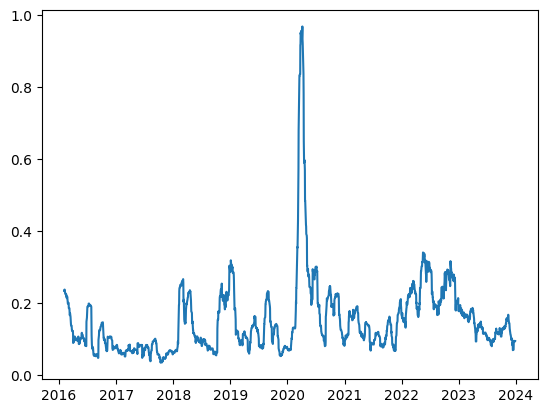

In [ ]:
plt.plot(spyHistory['21dRealisedVol'])

In [ ]:
spyHistIV['average_iv'].head()

Date
2017-01-03    0.180221
2017-01-04    0.157412
2017-01-05    0.167569
2017-01-06    0.132018
2017-01-09    0.142141
Name: average_iv, dtype: float64

In [ ]:

spyHistory['Daily Return']['2017':'2021'].head()

Date
2017-01-03    0.008487
2017-01-04    0.005722
2017-01-05   -0.000771
2017-01-06    0.003517
2017-01-09   -0.003549
Name: Daily Return, dtype: float64

In [ ]:
spyHistory['21dRealisedVol']['2017':'2021'].head()

Date
2017-01-03    0.082484
2017-01-04    0.083687
2017-01-05    0.082703
2017-01-06    0.082736
2017-01-09    0.072371
Name: 21dRealisedVol, dtype: float64

In [ ]:
historicIVSeries = spyHistIV['average_iv']
dailyReturnSeries= spyHistory['Daily Return']['2017':'2021']
dailyRealisedVolSeries = spyHistory['21dRealisedVol']['2017':'2021']
df_combined = pd.concat([historicIVSeries,dailyReturnSeries,dailyRealisedVolSeries], axis=1)

# Scale the data
scaler = preprocessing.StandardScaler().fit(df_combined)
scaled_data = scaler.transform(df_combined)

In [ ]:
data = scaled_data
seq_length = 60
n_features = data.shape[1]


In [ ]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 3):
        x = data[i:(i + seq_length)]
        y = data[(i + seq_length), 0]  # Next 3-day IV
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
X, y = create_sequences(data, seq_length)

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



In [ ]:
len(y)

1196

In [ ]:
model = keras.Sequential([
    layers.GRU(100, input_shape=(seq_length, n_features), return_sequences=False),
    layers.Dense(1)
])

In [ ]:
model.compile(optimizer='adam', loss='mse')


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=1, validation_split=0.2)


Epoch 1/50
797/797 [==============================] - 7s 6ms/step - loss: 0.1382 - val_loss: 0.0932
Epoch 2/50
797/797 [==============================] - 5s 6ms/step - loss: 0.1131 - val_loss: 0.0965
Epoch 3/50
797/797 [==============================] - 4s 5ms/step - loss: 0.1035 - val_loss: 0.0972
Epoch 4/50
797/797 [==============================] - 4s 5ms/step - loss: 0.1040 - val_loss: 0.0770
Epoch 5/50
797/797 [==============================] - 5s 6ms/step - loss: 0.0941 - val_loss: 0.0702
Epoch 6/50
797/797 [==============================] - 4s 5ms/step - loss: 0.0900 - val_loss: 0.1344
Epoch 7/50
797/797 [==============================] - 4s 5ms/step - loss: 0.1011 - val_loss: 0.0758
Epoch 8/50
797/797 [==============================] - 5s 6ms/step - loss: 0.0941 - val_loss: 0.1347
Epoch 9/50
797/797 [==============================] - 4s 5ms/step - loss: 0.0861 - val_loss: 0.0820
Epoch 10/50
797/797 [==============================] - 4s 5ms/step - loss: 0.0912 - val_loss: 0.0840

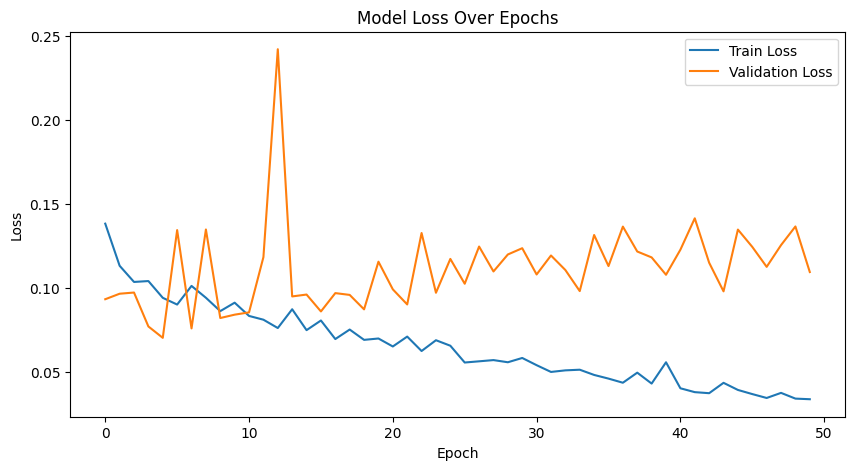

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

7/7 [==============================] - 0s 4ms/step - loss: 0.0516
Test Loss: 0.05162354186177254


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = model.predict(X_test)
y_test = np.array(y_test)  # Ensure y_test is a numpy array for consistency

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate R^2
r2 = r2_score(y_test, y_pred)
print("R squared:", r2)


7/7 [==============================] - 0s 3ms/step
Mean Squared Error: 0.05162353701759265
Root Mean Squared Error: 0.22720813589656655
Mean Absolute Error: 0.17569045972282246
R squared: 0.44441564355598107


In [1]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 3):
        x = data[i:(i + seq_length)]
        y = data[(i + seq_length), 0]  # Next 3-day IV
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def create_model(seq_length, n_features):
    model = keras.Sequential([
        layers.GRU(100, input_shape=(seq_length, n_features), return_sequences=False),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model
def evaluate_model(model, X_test, y_test):
    test_loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')

    y_pred = model.predict(X_test)
    y_test = np.array(y_test)  # Ensure y_test is a numpy array for consistency

    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    # Calculate RMSE
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:", rmse)

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)

    # Calculate R^2
    r2 = r2_score(y_test, y_pred)
    print("R squared:", r2)

    return mse, rmse, mae, r2

def train_model(X_train, y_train, X_test, y_test):
    model = create_model(seq_length, n_features)
    history = model.fit(X_train, y_train, epochs=50, batch_size=1, validation_split=0.2)
    evaluate_model(model, X_test, y_test)
    return model, history

def plot_loss(history):
    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

